<a href="https://colab.research.google.com/github/rdellavecchia/FaceSwap/blob/main/FSCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Video Face Swap basato su CGAN

## Configurazione dell'Ambiente

### Importazione delle librerie necessarie

In [1]:
import os
import torch
import cv2
import mediapipe as mp
import numpy as np
import json
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.5.3, so it will not be used.
  warnings.warn(


## Preparazione del Dataset (FFHQ con Annotazioni Mediapipe)

In [2]:
# Percorsi per dataset e salvataggio modelli
FFHQ_PATH = "/content/ffhq"
ANNOTATIONS_PATH = "/content/ffhq_annotations"
MODEL_SAVE_PATH = "/content/saved_models"

# Creazione delle directory se non esistono
os.makedirs(FFHQ_PATH, exist_ok=True)
os.makedirs(ANNOTATIONS_PATH, exist_ok=True)
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

### Mounting di Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Unpacking del dataset FFHQ

In [4]:
!unzip -j /content/drive/MyDrive/FSCGAN/flickrfaceshq-dataset-ffhq.zip -d {FFHQ_PATH}

Archive:  /content/drive/MyDrive/FSCGAN/flickrfaceshq-dataset-ffhq.zip
  inflating: /content/ffhq/00055.png  
  inflating: /content/ffhq/00237.png  
  inflating: /content/ffhq/00240.png  
  inflating: /content/ffhq/00241.png  
  inflating: /content/ffhq/00242.png  
  inflating: /content/ffhq/00243.png  
  inflating: /content/ffhq/00244.png  
  inflating: /content/ffhq/00245.png  
  inflating: /content/ffhq/00246.png  
  inflating: /content/ffhq/00247.png  
  inflating: /content/ffhq/00248.png  
  inflating: /content/ffhq/00249.png  
  inflating: /content/ffhq/00253.png  
  inflating: /content/ffhq/00255.png  
  inflating: /content/ffhq/00257.png  
  inflating: /content/ffhq/00258.png  
  inflating: /content/ffhq/00259.png  
  inflating: /content/ffhq/00260.png  
  inflating: /content/ffhq/00261.png  
  inflating: /content/ffhq/00262.png  
  inflating: /content/ffhq/00263.png  
  inflating: /content/ffhq/00264.png  
  inflating: /content/ffhq/00265.png  
  inflating: /content/ffhq/00266

### Visualizzazione di alcuni example del dataset FFHQ

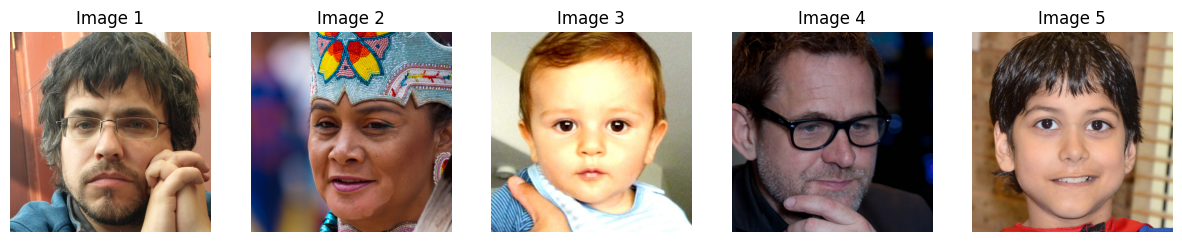

In [5]:
import random
import matplotlib.image as mpimg

image_folder = "/content/ffhq"

# Scelta randomica di 5 immagini dalla cartella
image_files = os.listdir(image_folder)
random_images = random.sample(image_files, 5)

# Plot delle immagini selezionate randomicamente
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, image_file in enumerate(random_images):
    img = mpimg.imread(os.path.join(image_folder, image_file))
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Image {i+1}")

###  Estrazione delle Annotazioni con Mediapipe

#### Inizializzazione di MediaPipe Face Mesh

In [6]:
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils

#### Rilevazione dei volti e memorizzazione dei landmark

In [7]:
def process_images():
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)
    annotations = {}

    image_files = [f for f in os.listdir(FFHQ_PATH) if f.endswith('.png') or f.endswith('.jpg')]

    for img_file in tqdm(image_files, desc="Processing images"):
        img_path = os.path.join(FFHQ_PATH, img_file)
        image = cv2.imread(img_path)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Rilevazione dei volti
        results = face_mesh.process(rgb_image)
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                landmark_list = []
                for lm in face_landmarks.landmark:
                    landmark_list.append([lm.x, lm.y, lm.z])

                annotations[img_file] = landmark_list

                # Rappresentazione dei landmark per il debug
                debug_img = image.copy()
                mp_drawing.draw_landmarks(
                    debug_img, face_landmarks, mp_face_mesh.FACEMESH_TESSELATION,
                    mp_drawing.DrawingSpec(color=(0,255,0), thickness=1, circle_radius=1),
                    mp_drawing.DrawingSpec(color=(0,0,255), thickness=1, circle_radius=1)
                )
                cv2.imwrite(os.path.join(ANNOTATIONS_PATH, img_file), debug_img)

    # Memorizzazione delle annotazioni JSON
    with open(os.path.join(ANNOTATIONS_PATH, "annotations.json"), "w") as f:
        json.dump(annotations, f, indent=4)

### Realizzazione del dataset FFHQ annotato

In [8]:
process_images()
print("✔️ Dataset preparato con successo!")

Processing images: 100%|██████████| 3143/3143 [06:29<00:00,  8.08it/s]


✔️ Dataset preparato con successo!


#### Visualizzazione di alcuni example del dataset FFHQ

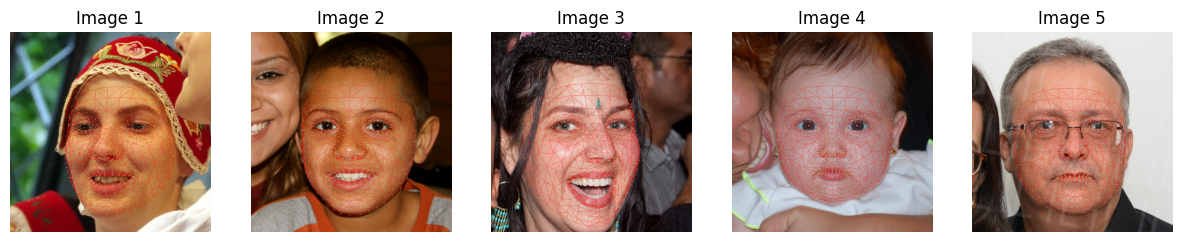

In [9]:
import random
import matplotlib.image as mpimg

image_folder = "/content/ffhq_annotations"

# Scelta randomica di 5 immagini dalla cartella
image_files = os.listdir(image_folder)
random_images = random.sample(image_files, 5)

# Plot delle immagini selezionate randomicamente
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, image_file in enumerate(random_images):
    img = mpimg.imread(os.path.join(image_folder, image_file))
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Image {i+1}")

## Creazione del Dataloader per il batch processing

### Downsampling delle immagini

In [10]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

###  Definizione della classe FFHQDataset

In [11]:
class FFHQDataset(Dataset):
    def __init__(self, img_dir, annotation_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        with open(annotation_file, "r") as f:
            self.annotations = json.load(f)
        self.image_files = list(self.annotations.keys())

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(image).permute(2, 0, 1).float() / 255.0

        landmarks = np.array(self.annotations[img_name], dtype=np.float32)

        return image, torch.tensor(landmarks)

### Creazione del DataLoader

In [12]:
batch_size = 32
ffhq_dataset = FFHQDataset(FFHQ_PATH, os.path.join(ANNOTATIONS_PATH, "annotations.json"), transform=transform)
ffhq_dataloader = DataLoader(ffhq_dataset, batch_size=batch_size, shuffle=True)

### Test del DataLoader

In [13]:
sample_image, sample_landmarks = next(iter(ffhq_dataloader))
print("✔️ DataLoader creato con successo!")
print("Shape immagine:", sample_image.shape)
print("Shape landmarks:", sample_landmarks.shape)

✔️ DataLoader creato con successo!
Shape immagine: torch.Size([32, 3, 256, 256])
Shape landmarks: torch.Size([32, 478, 3])


## Pre-caricamento Efficiente del Dataset per il Training

### Memorizzazione del dataset in formato PyTorch Tensor

In [14]:
# Lista per salvare i batch del DataLoader
data_list = []

# Iterazione sul DataLoader e salvataggio dei dati
for images, landmarks in ffhq_dataloader:
    data_list.append((images, landmarks))

# Salvataggio del dataset preprocessato su disco
torch.save(data_list, "ffhq_dataset.pt")
print("✅ Dataset salvato con successo!")


✅ Dataset salvato con successo!


### Salvataggio del file ffhq_dataset.pt su Google Drive

In [22]:
torch.save(data_list, "/content/drive/MyDrive/FSCGAN/ffhq_dataset.pt")

### Upload del file ffhq_dataset.pt su Google Drive

In [21]:
data_list = torch.load("/content/ffhq_dataset.pt")

## Implementazione del Generatore (G)

In [23]:
class ReenactmentGenerator(nn.Module):
    def __init__(self):
        super(ReenactmentGenerator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Inizializzazione del modello
G = ReenactmentGenerator().cuda()
print("✔️ Generatore di Reenactment inizializzato!")

✔️ Generatore di Reenactment inizializzato!


## Implementazione del Segmentatore del volto (G_s) con DeepLabV3 pre-addestrato

In [24]:
class FaceSegmentator(nn.Module):
    def __init__(self):
        super(FaceSegmentator, self).__init__()
        self.model = models.segmentation.deeplabv3_resnet50(pretrained=True)

        # Modifica della testa di classificazione
        classifier = list(self.model.classifier.children())  # Estrazione dei layer della testa
        classifier.insert(-1, nn.Dropout(0.3))  # Aggiunta di dropout prima dell'output finale

        # Sostituzione della vecchia testa con la nuova versione con Dropout
        self.model.classifier = nn.Sequential(*classifier)
        self.model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)  # Output per segmentazione binaria

    def forward(self, x):
        return torch.sigmoid(self.model(x)['out'])  # Applicazione della Sigmoid per maschera binaria

# Inizializzazione del Segmentatore
G_s = FaceSegmentator().cuda()
print("✔️ Segmentatore pre-addestrato inizializzato!")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 124MB/s]


✔️ Segmentatore pre-addestrato inizializzato!


## Implementazione della Rete di Inpainting (G_c) con LaMa pre-addestrato

In [1]:
class InpaintingNetwork(nn.Module):
    def __init__(self):
        super(InpaintingNetwork, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2]) # Si considera solo la parte convoluzionale

        # Decodifica con skip connections
        self.decoder = nn.Sequential(
            nn.Conv2d(2048, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),  # 32x32 -> 64x64

            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),  # 64x64 -> 128x128

            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),  # 128x128 -> 256x256

            nn.Conv2d(256, 3, kernel_size=3, padding=1),
            nn.Tanh()  # Output finale normalizzato tra -1 e 1
        )

    def forward(self, x):
        enc = self.encoder(x)
        out = self.decoder(enc)
        return out

# Inizializzazione della rete
G_c = InpaintingNetwork().cuda()
print("✔️ Rete di Inpainting aggiornata per 256x256 inizializzata!")

NameError: name 'nn' is not defined

## Implementazione della Rete di Blending (G_b) con StyleGAN2 pre-addestrato

In [33]:
class BlendingNetwork(nn.Module):
    def __init__(self):
        super(BlendingNetwork, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),
            nn.ReLU(),
            nn.Linear(512, 3 * 256 * 256),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x)
        return x.view(-1, 3, 256, 256)

# Inizializzazione della Rete di Blending
G_b = BlendingNetwork().cuda()
print("✔️ Rete di Blending con StyleGAN2 pre-addestrata inizializzata!")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✔️ Rete di Blending con StyleGAN2 pre-addestrata inizializzata!


## Implementazione del Discriminatore Multi-scala (D)

In [27]:
class MultiScaleDiscriminator(nn.Module):
    def __init__(self):
        super(MultiScaleDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Inizializzazione del Discriminatore
D = MultiScaleDiscriminator().cuda()
print("✔️ Discriminatore inizializzato!")

✔️ Discriminatore inizializzato!


## Implementazione delle Cost Functions

In [34]:
import torch.nn.functional as F

class LossFunctions:
    def __init__(self):
        super().__init__()

        # Caricamento di VGG19 per la perdita percettiva
        vgg_model = models.vgg19(pretrained=True).features
        self.vgg = nn.Sequential(*list(vgg_model[:21])).cuda().eval()  # Uso delle feature fino a conv4_2
        for param in self.vgg.parameters():
            param.requires_grad = False  # Blocco del training del modello VGG

        # Funzioni di perdita standard
        self.l1_loss = nn.L1Loss()
        self.bce_loss = nn.BCELoss()

        # Normalizzazione per VGG19 (basata su ImageNet)
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def perceptual_loss(self, x, y):
        """ Calcola la Perceptual Loss confrontando feature estratte da VGG19 """
        x, y = self.normalize(x), self.normalize(y)  # Normalizzazione per VGG
        x_features = self.vgg(x)
        y_features = self.vgg(y)
        return self.l1_loss(x_features, y_features)

    def inpainting_loss(self, generated, target):
        """ Combina L1 Loss e Perceptual Loss per migliorare l'inpainting """
        l1 = self.l1_loss(generated, target)
        perceptual = self.perceptual_loss(generated, target)
        return l1 + 0.1 * perceptual  # Bilanciamento tra le due loss

    def reconstruction_loss(self, x, y):
        """ Loss L1 per il confronto diretto tra immagini """
        return self.l1_loss(x, y)

    def adversarial_loss(self, pred, target):
        """ BCE Loss per la perdita avversariale """
        return self.bce_loss(pred, target)

    def poisson_blending_loss(self, generated, target):
      """ Perdita basata sulla differenza tra Laplaciani di Gaussiane """
      laplacian = nn.L1Loss()
      kernel = torch.tensor([[[[0, 1, 0], [1, -4, 1], [0, 1, 0]]]], dtype=torch.float32, device=generated.device)
      kernel = kernel.expand(3, 1, 3, 3)

      lap_gen = F.conv2d(generated, kernel, padding=1, groups=3)
      lap_target = F.conv2d(target, kernel, padding=1, groups=3)

      return laplacian(lap_gen, lap_target)

# Inizializzazione delle funzioni di costo
loss_functions = LossFunctions()
print("✔️ Funzioni di costo inizializzate!")

✔️ Funzioni di costo inizializzate!


## Implementazione del Ciclo di Training

In [37]:
# Definizione degli ottimizzatori
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_G_s = optim.Adam(G_s.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_G_c = optim.Adam(G_c.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_G_b = optim.Adam(G_b.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for images, _ in ffhq_dataloader:
        images = images.cuda()

        # Forward pass per G
        reenacted_images = G(images)
        reenactment_loss = loss_functions.reconstruction_loss(reenacted_images, images)
        optimizer_G.zero_grad()
        reenactment_loss.backward()
        optimizer_G.step()

        # Forward pass per G_s
        segmentations = G_s(images)
        segmentation_loss = loss_functions.reconstruction_loss(segmentations, torch.ones_like(segmentations))
        optimizer_G_s.zero_grad()
        segmentation_loss.backward()
        optimizer_G_s.step()

        # Forward pass per G_c
        inpainted_images = G_c(reenacted_images.detach())
        inpainting_loss = loss_functions.inpainting_loss(inpainted_images, images)
        optimizer_G_c.zero_grad()
        inpainting_loss.backward()
        optimizer_G_c.step()

        # Forward pass per G_b
        blended_input = torch.cat((images, inpainted_images.detach()), dim=1)
        blended_images = G_b(blended_input)
        blending_loss = loss_functions.poisson_blending_loss(blended_images, images)
        optimizer_G_b.zero_grad()
        blending_loss.backward()
        optimizer_G_b.step()

        # Forward pass per D
        optimizer_D.zero_grad()

        real_outputs = D(images).view(-1, 1)
        with torch.no_grad():
          fake_outputs = D(blended_images.detach()).view(-1, 1)

        # Creazione etichette con label smoothing
        real_labels = torch.full_like(real_outputs, 0.9)  # 0.9 invece di 1.0
        fake_labels = torch.full_like(fake_outputs, 0.1)  # 0.1 invece di 0.0

        d_loss = loss_functions.adversarial_loss(real_outputs, real_labels) + loss_functions.adversarial_loss(fake_outputs, fake_labels)
        d_loss.backward()
        optimizer_D.step()

    # Log dei progressi
    print(f"Epoch [{epoch+1}/{num_epochs}], G Loss: {reenactment_loss.item():.4f}, G_s Loss: {segmentation_loss.item():.4f}, G_c Loss: {inpainting_loss.item():.4f}, G_b Loss: {blending_loss.item():.4f}, D Loss: {d_loss.item():.4f}")

    # Salvataggio dei modelli a ogni epoca
    torch.save(G.state_dict(), os.path.join(MODEL_SAVE_PATH, 'G.pth'))
    torch.save(G_s.state_dict(), os.path.join(MODEL_SAVE_PATH, 'G_s.pth'))
    torch.save(G_c.state_dict(), os.path.join(MODEL_SAVE_PATH, 'G_c.pth'))
    torch.save(G_b.state_dict(), os.path.join(MODEL_SAVE_PATH, 'G_b.pth'))
    torch.save(D.state_dict(), os.path.join(MODEL_SAVE_PATH, 'D.pth'))

print("✔️ Training completato e modelli salvati!")

Epoch [1/10], G Loss: 0.0579, G_s Loss: 0.0408, G_c Loss: 0.1438, G_b Loss: 0.0456, D Loss: 79.2235
Epoch [2/10], G Loss: 0.0570, G_s Loss: 0.0164, G_c Loss: 0.1606, G_b Loss: 0.0410, D Loss: 79.5489
Epoch [3/10], G Loss: 0.0548, G_s Loss: 0.0086, G_c Loss: 0.1552, G_b Loss: 0.0532, D Loss: 79.7499
Epoch [4/10], G Loss: 0.0515, G_s Loss: 0.0053, G_c Loss: 0.1416, G_b Loss: 0.0402, D Loss: 79.9115
Epoch [5/10], G Loss: 0.0408, G_s Loss: 0.0035, G_c Loss: 0.1394, G_b Loss: 0.0412, D Loss: 80.0100
Epoch [6/10], G Loss: 0.0434, G_s Loss: 0.0025, G_c Loss: 0.1449, G_b Loss: 0.0443, D Loss: 80.1016
Epoch [7/10], G Loss: 0.0380, G_s Loss: 0.0020, G_c Loss: 0.1215, G_b Loss: 0.0423, D Loss: 80.2195
Epoch [8/10], G Loss: 0.0340, G_s Loss: 0.0014, G_c Loss: 0.1328, G_b Loss: 0.0404, D Loss: 80.2230
Epoch [9/10], G Loss: 0.0356, G_s Loss: 0.0012, G_c Loss: 0.1451, G_b Loss: 0.0457, D Loss: 84.8232
Epoch [10/10], G Loss: 0.0387, G_s Loss: 0.0009, G_c Loss: 0.1273, G_b Loss: 0.0446, D Loss: 95.0050